In [ ]:
#Esta es una nueva versión en la que quiero dar más énfasis a los enlaces reales que hay en el dataset 
#para así garantixar la fidelidad. Cambiando sobre todo la generación de negativos,añadir pos_weight y ajustar 
#hiperparámetros de entrenamiento.

## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import pickle
import torch
from torch_geometric.data import HeteroData
import torch.nn as nn
import networkx as nx
from tqdm import tqdm
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, to_hetero
import time
import matplotlib.pyplot as plt
import random
from torch_geometric.transforms import ToUndirected
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.transforms import RandomLinkSplit
from torch import Tensor
from sklearn.metrics import roc_auc_score, accuracy_score
import tqdm
import os
from sklearn.metrics import roc_auc_score, accuracy_score
import copy

## Crear nuestro Grafo

In [3]:
def create_drug_indication_graph(nodes_csv_path, edges_csv_path, embeddings_pkl_path, verbose=True):
    """
    Crea un grafo heterogéneo a partir de:
      - Un CSV de nodos que contiene columnas como "primaryDomainId", "type", "name", "description", etc.
      - Un CSV de edges que contiene, entre otros, las columnas "sourceDomainId", "targetDomainId" y una columna "relation"
        que puede tener valores como "DrugHasIndication", "DrugHasTarget", "ProteinEncodedByGene", "DisorderIsSubtypeOfDisorder", etc.
      - Un fichero .pkl con embeddings ya generados (por ejemplo, a partir de BERT) para cada nodo, mapeados mediante "primaryDomainId".
    
    El grafo resultante tendrá nodos agrupados por tipo (ej. "Drug", "Disorder", "Gene", "Protein") y edges etiquetados según la relación.
    Para nuestro objetivo, las relaciones de interés son las de tipo ("Drug", "DrugHasIndication", "Disorder").
    """
    data = HeteroData()
    
    # Cargar embeddings (suponemos que el .pkl tiene un diccionario con claves "Nodes Name" y "New Embedding")
    if verbose:
        print(f"[INFO] Cargando embeddings desde '{embeddings_pkl_path}'...")
    with open(embeddings_pkl_path, 'rb') as f:
        embeddings_dict = pickle.load(f)
    node_ids = embeddings_dict.get('Nodes Name', [])
    node_embeddings = embeddings_dict.get('New Embedding', [])
    embedding_map = {str(nid): np.array(emb) for nid, emb in zip(node_ids, node_embeddings)}
    
    # Cargar el CSV de nodos
    if verbose:
        print(f"[INFO] Cargando nodos desde '{nodes_csv_path}'...")
    nodes_df = pd.read_csv(nodes_csv_path, low_memory=False)
    
    # Crear un mapeo de nodo_id a tipo (usando la columna "type")
    id_to_type = {}
    # Inicializamos contenedores para cada tipo de nodo
    for ntype in ["Drug", "Disorder", "Gene", "Protein"]:
        data[ntype].x = []  # lista para acumular features
        data[ntype].id = []  # para almacenar el identificador original
    
    # Procesar cada nodo
    for _, row in nodes_df.iterrows():
        node_id = str(row['primaryDomainId'])
        node_type = row['type']
        # Solo procesamos los tipos de interés
        if node_type not in data.node_types:
            continue
        id_to_type[node_id] = node_type
        # Obtener la feature: si existe embedding para el nodo, lo usamos; si no, generamos un vector de ceros.
        if node_id in embedding_map:
            feat = embedding_map[node_id]
        else:
            # Supongamos dimensión 128 (ajusta según tu caso)
            feat = np.zeros(128)
        data[node_type].x.append(feat)
        data[node_type].id.append(node_id)
    
    # Convertir las listas de features a tensores para cada tipo de nodo
    for ntype in data.node_types:
        if len(data[ntype].x) > 0:
            features_array = np.array(data[ntype].x)
            data[ntype].x = torch.from_numpy(features_array).float()
            if hasattr(data[ntype], 'y') and isinstance(data[ntype].y, list):
                labels_array = np.array(data[ntype].y)
                data[ntype].y = torch.from_numpy(labels_array).long()
            if verbose:
                print(f"[INFO] {data[ntype].x.size(0)} nodos de tipo '{ntype}' con features de dimensión {data[ntype].x.size(1)}.")
        else:
            if verbose:
                print(f"[WARN] No se encontraron nodos de tipo '{ntype}'.")

    # Cargar el CSV de edges
    if verbose:
        print(f"[INFO] Cargando edges desde '{edges_csv_path}'...")
    edges_df = pd.read_csv(edges_csv_path, low_memory=False)
    
    # Procesar cada edge y agruparlos por tipo de relación
    # Se asume que el CSV de edges tiene columnas: "sourceDomainId", "targetDomainId" y "relation"
    edge_dict = {}  # clave: (src_type, relation, tgt_type) -> [lista de índices de origen, lista de índices de destino]
    for _, row in edges_df.iterrows():
        src_id = str(row['sourceDomainId'])
        tgt_id = str(row['targetDomainId'])
        relation = row['type']  # Ejemplos: "DrugHasIndication", "DrugHasTarget", etc.
        # Obtener tipos de nodo para el source y target
        src_type = id_to_type.get(src_id, None)
        tgt_type = id_to_type.get(tgt_id, None)
        if src_type is None or tgt_type is None:
            continue
        key = (src_type, relation, tgt_type)
        if key not in edge_dict:
            edge_dict[key] = [[], []]
        # Buscar el índice interno del nodo en su grupo
        try:
            src_idx = data[src_type].id.index(src_id)
            tgt_idx = data[tgt_type].id.index(tgt_id)
        except ValueError:
            continue
        edge_dict[key][0].append(src_idx)
        edge_dict[key][1].append(tgt_idx)
    
    # Agregar los edges al objeto HeteroData
    for (src_type, relation, tgt_type), (src_indices, tgt_indices) in edge_dict.items():
        edge_index = torch.tensor([src_indices, tgt_indices], dtype=torch.long)
        data[(src_type, relation, tgt_type)].edge_index = edge_index
        if verbose:
            print(f"[INFO] Agregados {edge_index.size(1)} edges para la relación ({src_type}, '{relation}', {tgt_type}).")
            
    #Añadir aristas inversas (reverse edges) para mejorar la propagación de información entre nodos y estabiliza el entrenamiento.        
    data = ToUndirected()(data)
    return data

#### Comprobaciones de que el grafo está bien hecho

In [4]:
def plot_graph_sample(data, max_nodes=100):
    """
    Visualiza un subgrafo del grafo heterogéneo, limitando la cantidad de nodos y edges para hacerlo legible.
    """
    G = nx.Graph()

    # Agregar nodos
    for node_type in data.node_types:
        num_nodes = data[node_type].x.shape[0]
        for i in range(min(num_nodes, max_nodes)):  # Limitar el número de nodos a mostrar
            G.add_node(f"{node_type}_{i}", label=node_type)

    # Agregar edges
    edge_colors = {}
    color_palette = ["r", "b", "g", "c", "m", "y"]
    
    for idx, edge_type in enumerate(data.edge_types):
        edge_index = data[edge_type].edge_index
        src_type, relation, tgt_type = edge_type
        color = color_palette[idx % len(color_palette)]  # Asignar un color diferente para cada tipo de relación
        edge_colors[relation] = color
        
        for i in range(min(edge_index.shape[1], max_nodes)):  # Limitar los edges a mostrar
            src = f"{src_type}_{edge_index[0, i].item()}"
            tgt = f"{tgt_type}_{edge_index[1, i].item()}"
            if src in G.nodes and tgt in G.nodes:
                G.add_edge(src, tgt, color=color)

    # Dibujar el grafo
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, seed=42)  # Layout para organizar los nodos
    edges = G.edges()
    edge_colors = [G[u][v]['color'] for u, v in edges]

    nx.draw(G, pos, with_labels=True, node_size=500, font_size=8, edge_color=edge_colors)
    plt.title("Visualización de un Subgrafo del Grafo de Drogas y Enfermedades")
    plt.show()


Creando el grafo...
[INFO] Cargando embeddings desde 'embeddings_mejorados_biobert.pkl'...
[INFO] Cargando nodos desde 'nodes.csv'...
[INFO] 7167 nodos de tipo 'Drug' con features de dimensión 768.
[INFO] 26015 nodos de tipo 'Disorder' con features de dimensión 768.
[INFO] 19394 nodos de tipo 'Gene' con features de dimensión 768.
[INFO] 30501 nodos de tipo 'Protein' con features de dimensión 768.
[INFO] Cargando edges desde 'edges.csv'...
[INFO] Agregados 48497 edges para la relación (Gene, 'GeneAssociatedWithDisorder', Disorder).
[INFO] Agregados 38881 edges para la relación (Disorder, 'DisorderIsSubtypeOfDisorder', Disorder).
[INFO] Agregados 30432 edges para la relación (Protein, 'ProteinEncodedByGene', Gene).
[INFO] Agregados 30088 edges para la relación (Drug, 'DrugHasTarget', Protein).
[INFO] Agregados 17728 edges para la relación (Drug, 'DrugHasIndication', Disorder).

 Resumen del grafo creado:
  - Drug: 7167 nodos
  - Disorder: 26015 nodos
  - Gene: 19394 nodos
  - Protein: 30

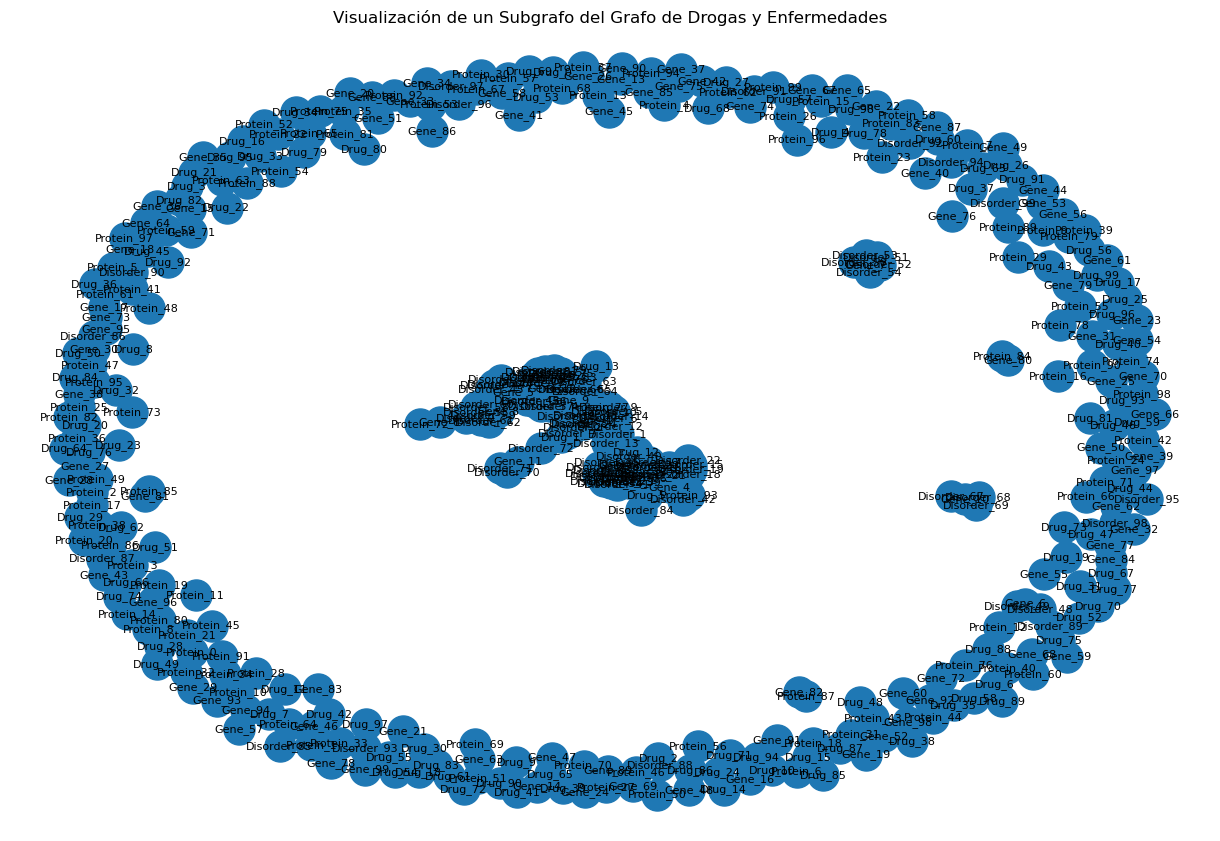

In [5]:
# Rutas a los archivos CSV y PKL
nodes_csv_path = "nodes.csv"
edges_csv_path = "edges.csv"
embeddings_pkl_path = "embeddings_mejorados_biobert.pkl"

# Crear el grafo
print("Creando el grafo...")
data = create_drug_indication_graph(nodes_csv_path, edges_csv_path, embeddings_pkl_path)

# Revisar nodos y edges
print("\n Resumen del grafo creado:")
for node_type in data.node_types:
    num_nodes = data[node_type].x.shape[0] if hasattr(data[node_type], "x") else 0
    print(f"  - {node_type}: {num_nodes} nodos")

for edge_type in data.edge_types:
    num_edges = data[edge_type].edge_index.shape[1]
    print(f"  - {edge_type}: {num_edges} edges")

# Visualizar el grafo
print("\n Generando visualización del grafo...")
plot_graph_sample(data)


In [6]:
#Como el anterior grafo no se ve bien, mejor probar con uno más pequeño
def plot_disorder_subgraph(data, disorder_index=None, max_connections=10):
    """
    Dibuja un subgrafo con un solo nodo 'Disorder' y sus conexiones con 'Drug' y otros nodos relacionados.
    
    Parámetros:
    - data: Grafo heterogéneo PyG.
    - disorder_index: Índice del disorder a visualizar (si es None, elige uno aleatorio).
    - max_connections: Máximo número de conexiones a mostrar.
    """
    G = nx.Graph()

    # Obtener lista de desórdenes
    disorder_nodes = data['Disorder'].id if hasattr(data['Disorder'], 'id') else []
    if not disorder_nodes:
        print(" No se encontraron nodos de tipo 'Disorder'.")
        return
    
    # Seleccionar un disorder aleatorio si no se especifica
    if disorder_index is None:
        disorder_index = random.choice(range(len(disorder_nodes)))
    
    disorder_node = f"Disorder_{disorder_index}"
    G.add_node(disorder_node, label="Disorder", color="red")

    # Buscar conexiones con otras entidades
    edge_types = [("Drug", "DrugHasIndication"), ("Gene", "GeneAssociatedWithDisorder")]
    
    connections = 0
    for target_type, relation in edge_types:
        if (target_type, relation, "Disorder") in data.edge_types:
            edge_index = data[(target_type, relation, "Disorder")].edge_index
            for i in range(edge_index.shape[1]):
                if edge_index[1, i].item() == disorder_index:
                    target_idx = edge_index[0, i].item()
                    target_node = f"{target_type}_{target_idx}"
                    G.add_node(target_node, label=target_type, color="blue" if target_type == "Drug" else "green")
                    G.add_edge(disorder_node, target_node, relation=relation)
                    connections += 1
                    if connections >= max_connections:
                        break
    
    if G.number_of_edges() == 0:
        print(f" El nodo 'Disorder_{disorder_index}' no tiene conexiones relevantes.")
        return

    # Dibujar el grafo
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G, seed=42)  
    colors = [G.nodes[n]["color"] for n in G.nodes]
    
    nx.draw(G, pos, with_labels=True, node_color=colors, node_size=1000, font_size=8, edge_color="gray")
    plt.title(f"Subgrafo de 'Disorder_{disorder_index}' y sus conexiones")
    plt.show()


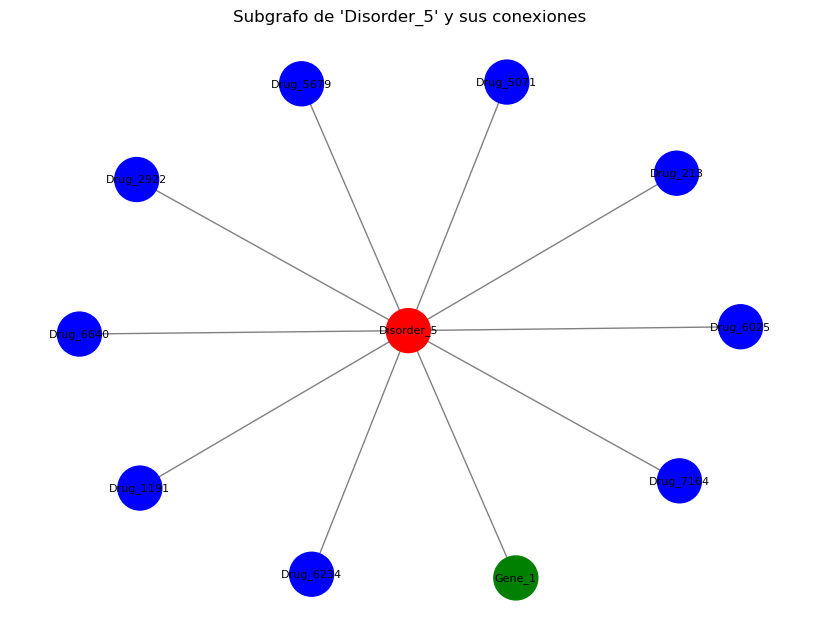

In [7]:
plot_disorder_subgraph(data, disorder_index=5)  # Si se quiere otra disorder se cambia el número


In [8]:
print(data)

HeteroData(
  Drug={
    x=[7167, 768],
    id=[7167],
  },
  Disorder={
    x=[26015, 768],
    id=[26015],
  },
  Gene={
    x=[19394, 768],
    id=[19394],
  },
  Protein={
    x=[30501, 768],
    id=[30501],
  },
  (Gene, GeneAssociatedWithDisorder, Disorder)={ edge_index=[2, 48497] },
  (Disorder, DisorderIsSubtypeOfDisorder, Disorder)={ edge_index=[2, 77762] },
  (Protein, ProteinEncodedByGene, Gene)={ edge_index=[2, 30432] },
  (Drug, DrugHasTarget, Protein)={ edge_index=[2, 30088] },
  (Drug, DrugHasIndication, Disorder)={ edge_index=[2, 17728] },
  (Disorder, rev_GeneAssociatedWithDisorder, Gene)={ edge_index=[2, 48497] },
  (Gene, rev_ProteinEncodedByGene, Protein)={ edge_index=[2, 30432] },
  (Protein, rev_DrugHasTarget, Drug)={ edge_index=[2, 30088] },
  (Disorder, rev_DrugHasIndication, Drug)={ edge_index=[2, 17728] }
)


## Pasos previos a entrenar el modelo 

### Dividir nuestro Heterodata para separarlo en train, val y test

In [12]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
import copy

# 1. Cargar el CSV limpio
df_edges = pd.read_csv("drug_has_indication_edges.csv").dropna()

# 2. Crear positivos
positive_edges = list(df_edges.itertuples(index=False, name=None))
drug_ids = df_edges["sourceDomainId"].unique().tolist()
disorder_ids = df_edges["targetDomainId"].unique().tolist()

# 3. Crear negativos
positive_set = set(positive_edges)
negatives = set()
while len(negatives) < len(positive_edges):
    d = random.choice(drug_ids)
    dis = random.choice(disorder_ids)
    if (d, dis) not in positive_set:
        negatives.add((d, dis))

# 4. Juntar todo y añadir etiquetas
all_edges = positive_edges + list(negatives)
all_labels = [1] * len(positive_edges) + [0] * len(negatives)
df_all = pd.DataFrame(all_edges, columns=["drug", "disorder"])
df_all["label"] = all_labels

# 5. Dividir en train, val, test
train_val, test = train_test_split(df_all, test_size=0.2, stratify=df_all["label"], random_state=42)
train, val = train_test_split(train_val, test_size=0.125, stratify=train_val["label"], random_state=42)

# 6. Crear mapeos de ID a índice en el grafo
drug_id_to_idx = {id_: i for i, id_ in enumerate(data["Drug"].id)}
disorder_id_to_idx = {id_: i for i, id_ in enumerate(data["Disorder"].id)}

# 7. Convertir dataframe a tensores de edge_label y edge_label_index
def df_to_edge_index_and_label(df, drug_map, disorder_map):
    edge_index = []
    labels = []
    for row in df.itertuples(index=False):
        d_id, dis_id, label = row
        if d_id in drug_map and dis_id in disorder_map:
            edge_index.append([drug_map[d_id], disorder_map[dis_id]])
            labels.append(label)
    edge_index = torch.tensor(edge_index).t().contiguous()
    edge_label = torch.tensor(labels, dtype=torch.float)
    return edge_index, edge_label

train_edge_index, train_edge_label = df_to_edge_index_and_label(train, drug_id_to_idx, disorder_id_to_idx)
val_edge_index, val_edge_label = df_to_edge_index_and_label(val, drug_id_to_idx, disorder_id_to_idx)
test_edge_index, test_edge_label = df_to_edge_index_and_label(test, drug_id_to_idx, disorder_id_to_idx)

# 8. Clonar el grafo original y añadir la información de enlaces
train_data = copy.deepcopy(data)
val_data = copy.deepcopy(data)
test_data = copy.deepcopy(data)

train_data["Drug", "DrugHasIndication", "Disorder"].edge_label_index = train_edge_index
train_data["Drug", "DrugHasIndication", "Disorder"].edge_label = train_edge_label

val_data["Drug", "DrugHasIndication", "Disorder"].edge_label_index = val_edge_index
val_data["Drug", "DrugHasIndication", "Disorder"].edge_label = val_edge_label

test_data["Drug", "DrugHasIndication", "Disorder"].edge_label_index = test_edge_index
test_data["Drug", "DrugHasIndication", "Disorder"].edge_label = test_edge_label

# 9. Comprobaciones básicas
print(f"Train: {len(train_edge_label)} enlaces ({(train_edge_label==1).sum()} positivos)")
print(f"Val:   {len(val_edge_label)} enlaces ({(val_edge_label==1).sum()} positivos)")
print(f"Test:  {len(test_edge_label)} enlaces ({(test_edge_label==1).sum()} positivos)")

print("Ejemplo train edge_label_index:", train_edge_index[:, :5])
print("Ejemplo train edge_label:", train_edge_label[:5])


Train: 24818 enlaces (12409 positivos)
Val:   3546 enlaces (1773 positivos)
Test:  7092 enlaces (3546 positivos)
Ejemplo train edge_label_index: tensor([[6640,  875, 7089, 6316, 5465],
        [ 517, 7994,  390, 1366, 3145]])
Ejemplo train edge_label: tensor([1., 0., 0., 0., 0.])


## Creación de nuestro modelo GraphSAGE

## Training

In [14]:
from train_gnn_model import Model, train_loop_ranking

model = Model(hidden_channels=768, dropout=0.3)
model = train_loop_ranking(
    model,
    train_data,
    val_data,
    epochs=100,
    lr=1e-4,
    weight_decay=1e-4,
    model_file="gnn_model_biobert_ranking.pth",
    device="cpu",  # o 'cpu'
    calc_recall_topk=200,
    calc_local_ranking=True,
    ndcg_k=50
)


C:\Users\gema\anaconda3\envs\TFM_NUEVO\lib\site-packages\torch_geometric\nn\fx.py:132: UserWarning: Found function 'dropout' with keyword argument 'training'. During FX tracing, this will likely be baked in as a constant value. Consider replacing this function by a module to properly encapsulate its training flag.
  warnings.warn(f"Found function '{node.name}' with keyword "
C:\Users\gema\anaconda3\envs\TFM_NUEVO\lib\site-packages\torch_geometric\nn\fx.py:132: UserWarning: Found function 'dropout_1' with keyword argument 'training'. During FX tracing, this will likely be baked in as a constant value. Consider replacing this function by a module to properly encapsulate its training flag.
  warnings.warn(f"Found function '{node.name}' with keyword "


Epoch 01 | TrainLoss=0.9827 | AUC=0.5354 | ValLoss=0.9972 | ValAUC=0.5311 | MRR_local=0.9040 | NDCG@50=0.9252
Epoch 02 | TrainLoss=0.9195 | AUC=0.6253 | ValLoss=0.9901 | ValAUC=0.5943 | MRR_local=0.9009 | NDCG@50=0.9243
Epoch 03 | TrainLoss=0.8704 | AUC=0.6638 | ValLoss=0.9848 | ValAUC=0.6195 | MRR_local=0.9121 | NDCG@50=0.9347
Epoch 04 | TrainLoss=0.8343 | AUC=0.6762 | ValLoss=0.9782 | ValAUC=0.6491 | MRR_local=0.9075 | NDCG@50=0.9300
Epoch 05 | TrainLoss=0.7802 | AUC=0.6962 | ValLoss=0.9772 | ValAUC=0.6355 | MRR_local=0.9223 | NDCG@50=0.9396
Epoch 06 | TrainLoss=0.7458 | AUC=0.7031 | ValLoss=0.9711 | ValAUC=0.6541 | MRR_local=0.9258 | NDCG@50=0.9417
Epoch 07 | TrainLoss=0.7217 | AUC=0.7035 | ValLoss=0.9602 | ValAUC=0.6810 | MRR_local=0.9178 | NDCG@50=0.9386
Epoch 08 | TrainLoss=0.6888 | AUC=0.7138 | ValLoss=0.9581 | ValAUC=0.6604 | MRR_local=0.9148 | NDCG@50=0.9356
Epoch 09 | TrainLoss=0.6739 | AUC=0.7159 | ValLoss=0.9453 | ValAUC=0.6871 | MRR_local=0.9234 | NDCG@50=0.9405
Epoch 10 |

## Evaluación

### Evaluación con métricas usando test_data

In [26]:
import torch
from train_gnn_model import Model
from torch_geometric.data import HeteroData

# 1. Crear el modelo
hidden_channels = 768
model = Model(hidden_channels=hidden_channels, dropout=0.3)

# 2. Mover a dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# 3. ⚠️ IMPORTANTE: pasa primero un forward con `data` para construir la arquitectura heterogénea
#Pasar train_data una sola vez es simplemente para que el modelo: sepa qué relaciones debe manejar,genere internamente 
#los módulos de tipo SAGEConv para cada tipo de relación.
#Este primer model(train_data) no entrena ni guarda nada. Es como una "llamada fantasma" para preparar la arquitectura.
_ = model(train_data)  

# 4. Ahora sí, puedes cargar los pesos
model.load_state_dict(torch.load("gnn_model_biobert_ranking.pth", map_location=device))



C:\Users\gema\anaconda3\envs\TFM_NUEVO\lib\site-packages\torch_geometric\nn\fx.py:132: UserWarning: Found function 'dropout' with keyword argument 'training'. During FX tracing, this will likely be baked in as a constant value. Consider replacing this function by a module to properly encapsulate its training flag.
  warnings.warn(f"Found function '{node.name}' with keyword "
C:\Users\gema\anaconda3\envs\TFM_NUEVO\lib\site-packages\torch_geometric\nn\fx.py:132: UserWarning: Found function 'dropout_1' with keyword argument 'training'. During FX tracing, this will likely be baked in as a constant value. Consider replacing this function by a module to properly encapsulate its training flag.
  warnings.warn(f"Found function '{node.name}' with keyword "


<All keys matched successfully>

In [ ]:
## evaluar en test_data y luego calculas métricas con ese pred
model.eval()
pred = model(test_data)



In [27]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score
from train_gnn_model import (
    evaluate_local_ranking_metrics,
    sample_pos_neg_for_margin,
    compute_recall_at_k
)

@torch.no_grad()
def evaluate_test_metrics(model, test_data, device='cpu', k_recall=100, ndcg_k=50):
    model.eval()
    test_data = test_data.to(device)

    pred = model(test_data)  # logits
    probs = torch.sigmoid(pred).cpu().numpy()
    labels = test_data["Drug", "DrugHasIndication", "Disorder"].edge_label.cpu().numpy()

    # AUC y Accuracy
    auc = roc_auc_score(labels, probs) if len(np.unique(labels)) > 1 else 0.0
    acc = accuracy_score(labels, (probs >= 0.5))

    # Recall@k
    recall_k = compute_recall_at_k(probs, labels, k=k_recall)

    # Ranking local
    mrr_local, ndcg_local = evaluate_local_ranking_metrics(
        model, test_data, device=device, ndcg_k=ndcg_k
    )

    print("📊 Evaluación en Test:")
    print(f"  - AUC           : {auc:.4f}")
    print(f"  - Accuracy      : {acc:.4f}")
    print(f"  - Recall@{k_recall:>2}    : {recall_k:.4f}")
    print(f"  - MRR Local     : {mrr_local:.4f}")
    print(f"  - NDCG@{ndcg_k}       : {ndcg_local:.4f}")

    return {
        "AUC": auc,
        "Accuracy": acc,
        f"Recall@{k_recall}": recall_k,
        "MRR_local": mrr_local,
        f"NDCG@{ndcg_k}": ndcg_local
    }

# Ejecutar evaluación:
metrics = evaluate_test_metrics(model, test_data, device=device)


📊 Evaluación en Test:
  - AUC           : 0.8889
  - Accuracy      : 0.8056
  - Recall@100    : 0.0276
  - MRR Local     : 0.9356
  - NDCG@50       : 0.9488


### Evaluación de la relación drug --> disorder

In [ ]:
"""
Breve explicación sobre Link Prediction y por qué puede que el modelo
no muestre primero un enlace real del dataset:

En problemas de Link Prediction, el modelo (en este caso, una GNN) aprende
patrones de las aristas existentes (DrugHasIndication, etc.) para predecir
la probabilidad de enlaces nuevos o no observados. Al inferir (por ejemplo,
al pedir "top 5 disorders" para una cierta drug), el modelo rankea todas
las posibles conexiones según la probabilidad aprendida.

Es posible que un enlace 'real' (por ejemplo, (drug=6881, disorder=42))
aparezca lejos en el ranking (en el puesto 1817 en mi caso, con prob alta igualmente) incluso si
sí existe en el dataset. Esto sucede porque:

1) El modelo no está obligado a reproducir fielmente los enlaces originales
   en el top. Su objetivo es generalizar patrones aprendidos; puede “preferir”
   otras conexiones con puntuaciones aún mayores.
2) Durante el entrenamiento, la evidencia de ese enlace pudo no haber sido
   lo bastante fuerte (o quedó diluida) frente a otras asociaciones con
   características similares, resultando en una menor probabilidad final.
3) Link Prediction produce una ordenación estadística de la probabilidad
   de cada enlace, pero no garantiza que los enlaces “reales” queden siempre
   en los primeros lugares.

En resumen, que un enlace real del dataset no aparezca en el top N no es
un error: el modelo simplemente aprendió que, según sus patrones, otras
conexiones son más probables. Aun así, sigue asignándole una cierta
probabilidad (>0.8, por ejemplo), y confirma que “conoce” ese enlace, 
aunque no lo destaque en los primeros puestos.

Además es típico que un modelo de link prediction pueda sugerir fármacos sin respaldo clínico para esa enfermedad concreta, 
dado que se basa en patrones estadísticos de tu base de datos y no en evidencia médica directa.

el resultado del modelo debe tomarse solo como una hipótesis estadística, no como recomendación terapéutica.
"""


In [36]:
import torch
import pandas as pd
from train_gnn_model import Model

# -----------------------------------------
# 1. Cargar nodos para mapear ID → nombre
# -----------------------------------------
df_nodes = pd.read_csv("nodes.csv", low_memory=False)
id_to_name = df_nodes.set_index("primaryDomainId")["displayName"].to_dict()

# -----------------------------------------
# 2. Preparar modelo y cargar pesos entrenados
# -----------------------------------------
model = Model(hidden_channels=768, dropout=0.3)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

# ⚠️ Inicializa `hetero_gnn` con test_data (que tiene edge_label_index)
with torch.no_grad():
    _ = model(test_data.to(device))  # No genera error

# Ahora ya puedes cargar los pesos
model.load_state_dict(torch.load("gnn_model_biobert_ranking.pth", map_location=device))
model.eval()

# -----------------------------------------
# 3. Obtener embeddings de todos los nodos
# -----------------------------------------
@torch.no_grad()
def get_node_embeddings(model, data):
    model.eval()
    x_dict = {
        "Drug": model.drug_lin(data["Drug"].x.to(device)),
        "Disorder": model.disorder_lin(data["Disorder"].x.to(device)),
        "Protein": model.protein_lin(data["Protein"].x.to(device)),
        "Gene": model.gene_lin(data["Gene"].x.to(device)),
    }
    return model.hetero_gnn(x_dict, data.edge_index_dict)

embeddings = get_node_embeddings(model, data)

# -----------------------------------------
# 4. Función para predicción top-k
# -----------------------------------------
def predict_top_k_links(embeddings, source_type, target_type, input_id, k=5):
    source_ids = data[source_type].id  # ⚠️ Ya es una lista
    target_ids = data[target_type].id

    if input_id not in source_ids:
        raise ValueError(f"ID '{input_id}' no encontrado en los nodos de tipo '{source_type}'.")

    source_idx = source_ids.index(input_id)
    source_emb = embeddings[source_type][source_idx]

    all_target_embs = embeddings[target_type]
    scores = torch.nn.functional.cosine_similarity(
        source_emb.unsqueeze(0), all_target_embs
    )

    top_k_idx = torch.topk(scores, k=k).indices.tolist()
    top_k_ids = [target_ids[i] for i in top_k_idx]
    top_k_scores = [scores[i].item() for i in top_k_idx]

    return [(id_to_name.get(tid, tid), score) for tid, score in zip(top_k_ids, top_k_scores)]

# -----------------------------------------
# 5. Ejemplo: Predecir enfermedades asociadas a un fármaco
# -----------------------------------------
input_drug_id = "drugbank.DB00001"
k = 5
print(f"\n🔍 Fármaco: {id_to_name.get(input_drug_id, input_drug_id)}")
print("Enfermedades predichas:")

for name, score in predict_top_k_links(embeddings, "Drug", "Disorder", input_drug_id, k=k):
    print(f"  - {name} (score={score})")

# -----------------------------------------
# 6. Ejemplo inverso: Predecir medicamentos para una enfermedad
# -----------------------------------------
input_disorder_id = "mondo.0004975"
k = 5
print(f"\n🔍 Enfermedad: {id_to_name.get(input_disorder_id, input_disorder_id)}")
print("Fármacos predichos:")

for name, score in predict_top_k_links(embeddings, "Disorder", "Drug", input_disorder_id, k=k):
    print(f"  - {name} (score={score})")

C:\Users\gema\anaconda3\envs\TFM_NUEVO\lib\site-packages\torch_geometric\nn\fx.py:132: UserWarning: Found function 'dropout' with keyword argument 'training'. During FX tracing, this will likely be baked in as a constant value. Consider replacing this function by a module to properly encapsulate its training flag.
  warnings.warn(f"Found function '{node.name}' with keyword "
C:\Users\gema\anaconda3\envs\TFM_NUEVO\lib\site-packages\torch_geometric\nn\fx.py:132: UserWarning: Found function 'dropout_1' with keyword argument 'training'. During FX tracing, this will likely be baked in as a constant value. Consider replacing this function by a module to properly encapsulate its training flag.
  warnings.warn(f"Found function '{node.name}' with keyword "



🔍 Fármaco: Lepirudin
Enfermedades predichas:
  - human herpesvirus 8 infection (score=0.39885273575782776)
  - myopia, non-human animal (score=0.3629685342311859)
  - isolated congenital entropion (score=0.3180578351020813)
  - blepharophimosis-ptosis-esotropia-syndactyly-short stature syndrome (score=0.31394320726394653)
  - cutaneous mycosis (score=0.30406510829925537)

🔍 Enfermedad: Alzheimer disease
Fármacos predichos:
  - Metoprine (score=0.19710597395896912)
  - Retapamulin (score=0.19643908739089966)
  - LAX-101 (score=0.1959010809659958)
  - Aplyronine A (score=0.18601825833320618)
  - GLPG-0974 (score=0.18033918738365173)


In [37]:
def predict_links_with_threshold(embeddings, source_type, target_type, input_id, 
                                 id_to_name, threshold=0.4, top_k=10):
    """
    Devuelve predicciones que superan un cierto umbral de similitud, ordenadas por score.
    Si no se alcanza el mínimo, devuelve el top_k.
    """
    source_ids = data[source_type].id
    target_ids = data[target_type].id

    if input_id not in source_ids:
        raise ValueError(f"ID '{input_id}' no encontrado en los nodos de tipo '{source_type}'.")

    source_idx = source_ids.index(input_id)
    source_emb = embeddings[source_type][source_idx]
    all_target_embs = embeddings[target_type]

    scores = torch.nn.functional.cosine_similarity(source_emb.unsqueeze(0), all_target_embs)

    # Orden descendente por score
    sorted_scores, sorted_idx = torch.sort(scores, descending=True)
    results = []

    for idx in sorted_idx:
        score = sorted_scores[idx].item()
        if score < threshold and len(results) >= top_k:
            break
        target_id = target_ids[idx]
        name = id_to_name.get(target_id, target_id)
        results.append((name, score))

    return results


In [38]:
# Fármaco → Enfermedades con umbral
input_drug_id = "drugbank.DB00001"
print(f"\n🔍 Fármaco: {id_to_name.get(input_drug_id, input_drug_id)}")
print("Enfermedades predichas (score > 0.4):")
for name, score in predict_links_with_threshold(embeddings, "Drug", "Disorder", input_drug_id, id_to_name):
    print(f"  - {name} (score={score:.4f})")

# Enfermedad → Fármacos con umbral
input_disorder_id = "mondo.0004975"
print(f"\n🔍 Enfermedad: {id_to_name.get(input_disorder_id, input_disorder_id)}")
print("Fármacos predichos (score > 0.4):")
for name, score in predict_links_with_threshold(embeddings, "Disorder", "Drug", input_disorder_id, id_to_name):
    print(f"  - {name} (score={score:.4f})")



🔍 Fármaco: Lepirudin
Enfermedades predichas (score > 0.4):
  - human herpesvirus 8 infection (score=0.0226)
  - myopia, non-human animal (score=-0.0919)
  - isolated congenital entropion (score=-0.0559)
  - blepharophimosis-ptosis-esotropia-syndactyly-short stature syndrome (score=0.0065)
  - cutaneous mycosis (score=0.0620)
  - diprosopus, non-human animal (score=-0.0874)
  - multiple epiphyseal dysplasia, Lowry type (score=-0.0034)
  - linear atrophoderma of Moulin (score=-0.0162)
  - limb-girdle muscular dystrophy, SGCD-related, dog (score=-0.1036)
  - lentigo maligna melanoma (score=-0.0439)

🔍 Enfermedad: Alzheimer disease
Fármacos predichos (score > 0.4):
  - Metoprine (score=-0.0350)
  - Retapamulin (score=-0.1751)
  - LAX-101 (score=-0.0449)
  - Aplyronine A (score=-0.0346)
  - GLPG-0974 (score=-0.1319)
  - CA-170 (score=-0.1337)
  - SB-409513 (score=0.0094)
  - OSI-461 (score=-0.0461)
  - FLX475 (score=-0.1325)
  - Malachite Green (score=-0.2153)


In [43]:
from tqdm import tqdm

def top_diseases_with_highest_scores(embeddings, id_to_name, k=5, top_n=5):
    disorder_ids = data["Disorder"].id  # Lista de IDs reales
    results = []

    for disorder_id in tqdm(disorder_ids[:1000]):  # Puedes limitar a 1000 para rapidez
        disorder_name = id_to_name.get(disorder_id, disorder_id)
        predictions = predict_top_k_links(
            embeddings, "Disorder", "Drug", disorder_id, k=k
        )
        avg_score = np.mean([score for _, score in predictions])
        results.append((disorder_id, disorder_name, avg_score, predictions))

    # Ordenar por score medio
    top_results = sorted(results, key=lambda x: x[2], reverse=True)[:top_n]

    # Mostrar
    for disorder_id, disorder_name, avg_score, preds in top_results:
        print(f"\n🔍 Enfermedad: {disorder_name} (score promedio top-{k} = {avg_score:.4f})")
        for drug_name, score in preds:
            print(f"  - {drug_name} (score={score:.4f})")

    return top_results


In [48]:
top_results = top_diseases_with_highest_scores(embeddings, id_to_name, k=5, top_n=5)


100%|██████████| 1000/1000 [00:06<00:00, 152.57it/s]


🔍 Enfermedad: spondyloepiphyseal dysplasia, Kimberley type (score promedio top-5 = 0.3374)
  - Patent Blue (score=0.3880)
  - Cis-[4,5-Bis-(4-Bromophenyl)-2-(2-Ethoxy-4-Methoxyphenyl)-4,5-Dihydroimidazol-1-Yl]-[4-(2-Hydroxyethyl)Piperazin-1-Yl]Methanone (score=0.3611)
  - ATYR1923 (score=0.3300)
  - 3-[3-(3-methyl-6-{[(1S)-1-phenylethyl]amino}-1H-pyrazolo[4,3-c]pyridin-1-yl)phenyl]propanamide (score=0.3070)
  - Enoxaparin (score=0.3008)

🔍 Enfermedad: myocardial stunning (score promedio top-5 = 0.3327)
  - Metoprine (score=0.3762)
  - Hexestrol (score=0.3394)
  - Isopentyl Pyrophosphate (score=0.3272)
  - Pyrantel (score=0.3169)
  - 1-(4-Methoxyphenyl)-3,5-Dimethyl-1h-Pyrazole-4-Carboxylic Acid Ethyl Ester (score=0.3039)

🔍 Enfermedad: thiamine-responsive maple syrup urine disease (score promedio top-5 = 0.3298)
  - Oxytetracycline (score=0.3456)
  - Ceftobiprole (score=0.3318)
  - Moxidectin (score=0.3284)
  - Docosanol (score=0.3221)
  - Chlorine dioxide (score=0.3209)

🔍 Enfermedad

In [41]:
def top_drugs_with_highest_scores(embeddings, id_to_name, k=5, top_n=5):
    drug_ids = data["Drug"].id  # Lista de IDs reales
    results = []

    for drug_id in tqdm(drug_ids[:1000]):  # Puedes limitar a 1000 para rapidez
        drug_name = id_to_name.get(drug_id, drug_id)
        predictions = predict_top_k_links(
            embeddings, "Drug", "Disorder", drug_id, k=k
        )
        avg_score = np.mean([score for _, score in predictions])
        results.append((drug_id, drug_name, avg_score, predictions))

    # Ordenar por score medio
    top_results = sorted(results, key=lambda x: x[2], reverse=True)[:top_n]

    # Mostrar
    for drug_id, drug_name, avg_score, preds in top_results:
        print(f"\n💊 Fármaco: {drug_name} (score promedio top-{k} = {avg_score:.4f})")
        for disorder_name, score in preds:
            print(f"  - {disorder_name} (score={score:.4f})")

    return top_results


In [51]:
top_drugs_with_highest_scores(embeddings, id_to_name, k=5, top_n=5)


100%|██████████| 1000/1000 [00:23<00:00, 43.03it/s]


💊 Fármaco: Dolasetron (score promedio top-5 = 0.3754)
  - steroid inherited metabolic disorder (score=0.4132)
  - advanced heart failure (score=0.3714)
  - symptomatic form of fragile X syndrome in female carrier (score=0.3650)
  - Aphalangy-hemivertebrae-urogenital-intestinal dysgenesis syndrome (score=0.3638)
  - Y chromosome infertility due to DAZ1 deletion (score=0.3637)

💊 Fármaco: Ornithine (score promedio top-5 = 0.3740)
  - oculopharyngeal muscular dystrophy 1 (score=0.4471)
  - endometrial mixed adenocarcinoma (score=0.3584)
  - peroxisome biogenesis disorder due to PEX11B defect (score=0.3577)
  - polysyndactyly, bilateral (score=0.3554)
  - X-linked intellectual disability, Golabi-Ito-hall type (score=0.3515)

💊 Fármaco: Cycrimine (score promedio top-5 = 0.3706)
  - cervical small cell carcinoma (score=0.3885)
  - premature ovarian failure 23 (score=0.3746)
  - adenoid cystic carcinoma of the corpus uteri (score=0.3679)
  - primary intraosseous squamous cell carcinoma (scor

[('drugbank.DB00757',
  'Dolasetron',
  0.3754312753677368,
  [('steroid inherited metabolic disorder', 0.4132384657859802),
   ('advanced heart failure', 0.3713865578174591),
   ('symptomatic form of fragile X syndrome in female carrier',
    0.3650452494621277),
   ('Aphalangy-hemivertebrae-urogenital-intestinal dysgenesis syndrome',
    0.3638065457344055),
   ('Y chromosome infertility due to DAZ1 deletion', 0.36367955803871155)]),
 ('drugbank.DB00129',
  'Ornithine',
  0.3740425229072571,
  [('oculopharyngeal muscular dystrophy 1', 0.4471365809440613),
   ('endometrial mixed adenocarcinoma', 0.3584370017051697),
   ('peroxisome biogenesis disorder due to PEX11B defect',
    0.35773852467536926),
   ('polysyndactyly, bilateral', 0.3553723096847534),
   ('X-linked intellectual disability, Golabi-Ito-hall type',
    0.35152819752693176)]),
 ('drugbank.DB00942',
  'Cycrimine',
  0.3705629348754883,
  [('cervical small cell carcinoma', 0.38849887251853943),
   ('premature ovarian failu